Download the data from https://cocodataset.org/#download
* 2017 Train images
* 2017 Test images
* 2017 Val images
* 2017 annotations

Extract the zip files to the /temp directory.
```
temp/
├── annotations/
│   ├── captions_train2017.json
│   ├── captions_val2017.json
│   ├── instances_train2017.json
│   ├── instances_val2017.json
│   ├── person_keypoints_train2017.json
│   ├── person_keypoints_val2017.json
├── test2017/
├── train2017/
├── val2017/
```

In [18]:
from torchvision.datasets import CocoDetection
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from PIL import Image
import json
import os
import random

In [2]:
transform = transforms.ToTensor()
train_dataset = CocoDetection(
    root='temp/train2017',
    annFile='temp/annotations/instances_train2017.json',
    transform=transform
)
val_dataset = CocoDetection(
    root='temp/val2017',
    annFile='temp/annotations/instances_val2017.json',
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

loading annotations into memory...
Done (t=24.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.77s)
creating index...
index created!


To explore the contents of instances_val2017.json and understand the structure of COCO annotations, you can use Python with the json module.

In [6]:
# Load the annotations
with open('temp/annotations/instances_val2017.json', 'r') as f:
    coco_data = json.load(f)

# Explore top-level keys
print(coco_data.keys())

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [7]:
print(coco_data['images'][0])

{'license': 4, 'file_name': '000000397133.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-14 17:02:52', 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg', 'id': 397133}


In [8]:
print(coco_data['annotations'][0])

{'segmentation': [[510.66, 423.01, 511.72, 420.03, 510.45, 416.0, 510.34, 413.02, 510.77, 410.26, 510.77, 407.5, 510.34, 405.16, 511.51, 402.83, 511.41, 400.49, 510.24, 398.16, 509.39, 397.31, 504.61, 399.22, 502.17, 399.64, 500.89, 401.66, 500.47, 402.08, 499.09, 401.87, 495.79, 401.98, 490.59, 401.77, 488.79, 401.77, 485.39, 398.58, 483.9, 397.31, 481.56, 396.35, 478.48, 395.93, 476.68, 396.03, 475.4, 396.77, 473.92, 398.79, 473.28, 399.96, 473.49, 401.87, 474.56, 403.47, 473.07, 405.59, 473.39, 407.71, 476.68, 409.41, 479.23, 409.73, 481.56, 410.69, 480.4, 411.85, 481.35, 414.93, 479.86, 418.65, 477.32, 420.03, 476.04, 422.58, 479.02, 422.58, 480.29, 423.01, 483.79, 419.93, 486.66, 416.21, 490.06, 415.57, 492.18, 416.85, 491.65, 420.24, 492.82, 422.9, 493.56, 424.39, 496.43, 424.6, 498.02, 423.01, 498.13, 421.31, 497.07, 420.03, 497.07, 415.15, 496.33, 414.51, 501.1, 411.96, 502.06, 411.32, 503.02, 415.04, 503.33, 418.12, 501.1, 420.24, 498.98, 421.63, 500.47, 424.39, 505.03, 423.32

In [17]:
print(coco_data['categories'][:3])

[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}]


Here's a complete function to visualize COCO images with bounding boxes and category labels using pycocotools, matplotlib, and PIL.

In [19]:
def show_coco_image_with_annotations(img_dir, ann_file, image_id=None):
    # Load COCO annotations
    coco = COCO(ann_file)

    if image_id is None:
        img_ids = coco.getImgIds()
        image_id = img_ids[0]  # or random.choice(img_ids)

    # Load image info and open image
    img_info = coco.loadImgs(image_id)[0]
    img_path = os.path.join(img_dir, img_info['file_name'])
    image = Image.open(img_path).convert("RGB")

    # Load annotations for the image
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)

    # Assign random colors to categories
    category_colors = {}
    for category in coco.loadCats(coco.getCatIds()):
        category_colors[category['id']] = (
            random.random(), random.random(), random.random()
        )

    # Create plot
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    # Draw bounding boxes and labels
    for ann in anns:
        bbox = ann['bbox']  # [x, y, width, height]
        category_id = ann['category_id']
        category_name = coco.loadCats(category_id)[0]['name']
        
        # Get color for the category
        color = category_colors[category_id]

        # Draw bounding box
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), 
            bbox[2], 
            bbox[3],
            linewidth=2, 
            edgecolor=color, 
            facecolor='none'
        )
        ax.add_patch(rect)

        # Label
        ax.text(bbox[0], bbox[1] - 2, category_name, fontsize=12,
                color='white', bbox=dict(facecolor=color, alpha=0.5))

    ax.axis('off')
    plt.tight_layout()
    plt.show()

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!


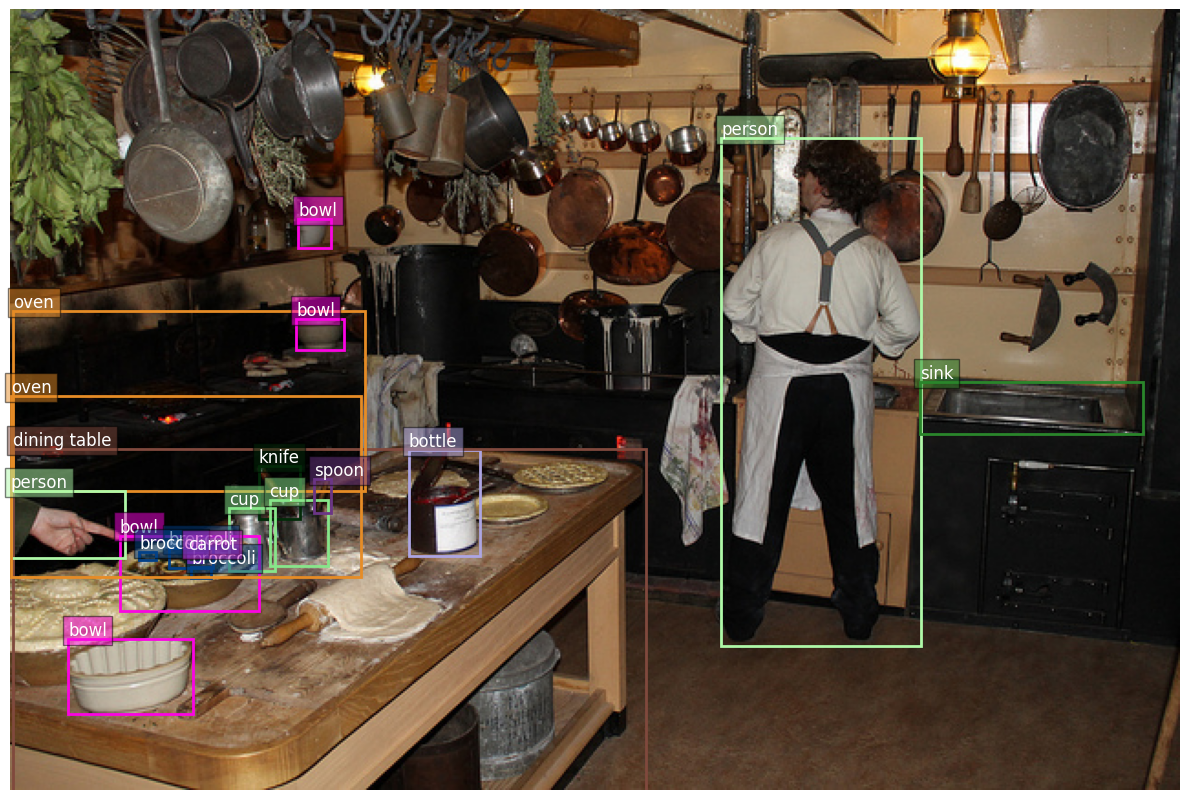

In [20]:
show_coco_image_with_annotations(
    img_dir='temp/val2017',
    ann_file='temp/annotations/instances_val2017.json',
    image_id=397133  # Optional: specify an ID or leave blank for first image
)